# Descriptive and Predictive Analytics Group Project - DSC Case

Group 5:
    
    Pooja SHAH
    Roxane SMADJA
    Rohit BHALERAO
    Alessio ROSATO

## Import Libraries

In [1]:
#!pip install mlxtend

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from pandas import DataFrame
from numpy import array
import scipy.stats as stats

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from itertools import combinations
from sklearn.base import clone

# ieseg package
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains



## Fetch the data

In [3]:
# Reading the data
donors = pd.read_csv('data/donors.csv', delimiter = ';')
gifts = pd.read_csv('data/gifts.csv', delimiter = ';')
campaigns = pd.read_csv('data/campaigns.csv', delimiter = ';')
camp7244 = pd.read_csv('data/selection campaign 7244.csv', delimiter = ';')
camp6169 = pd.read_csv('data/selection campaign 6169.csv', delimiter = ';')

## Analyze the data

#### Donors table

In [4]:
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25


In [5]:
# Add age column
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])
donors["age"] = donors["dateOfBirth"].apply(lambda x : (2019 - x.year))

# NA values in zipcode
donors.loc[donors['zipcode'].isna(), 'donorID']

# NA values in region
donors.loc[donors['region'] == 'Missing', 'donorID']

# NA values in gender
donors.loc[donors['gender'].isna(), 'donorID']

83       100084
217      100218
512      100513
552      100553
729      100730
883      100884
1056     101057
2050     102051
2209     102210
2379     102380
2619     102620
2811     102812
2944     102945
16375    116376
16497    116498
16513    116514
26537    126538
26677    126678
26799    126800
26883    126884
27095    127096
27286    127287
27533    127534
27620    127621
27721    127722
27878    127879
28022    128023
28439    128440
29030    129031
37197    137198
44646    144647
44682    144683
Name: donorID, dtype: int64

In [6]:
donors.isna().sum()
donors.dtypes

donorID                 int64
zipcode               float64
province               object
region                 object
gender                 object
language               object
dateOfBirth    datetime64[ns]
age                     int64
dtype: object

In [7]:
#Replace male and female by dummy encoding
donors.loc[donors['gender'] == 'F', 'IsMale'] = 0
donors.loc[donors['gender'] == 'M', 'IsMale'] = 1
donors.loc[donors['gender'].isna(), 'IsMale'] = 0

donors.loc[donors['gender'] == 'F', 'IsFemale'] = 1
donors.loc[donors['gender'] == 'M', 'IsFemale'] = 0
donors.loc[donors['gender'].isna(), 'IsFemale'] = 0

# Create a new flag variable with 0 if the gender is available and 1 if it is missing

donors['IsMissingGender'] = 0
donors.loc[donors['gender'].isna(), 'IsMissingGender'] = 1 
donors.IsMissingGender = donors.IsMissingGender.astype(int)

donors['IsMale'] = donors['IsMale'].astype(int)
donors['IsFemale'] = donors['IsFemale'].astype(int)


In [8]:
# Create new flag variables with 0 if the zipcode, province, and region are available and 1 if they are missing

donors['IsMissingZipCode'] = 0
donors['IsMissingProvince'] = 0
donors['IsMissingRegion'] = 0
donors.loc[donors['zipcode'].isna(), 'IsMissingZipCode'] = 1 
donors.loc[donors['province'] == 'Missing', 'IsMissingProvince'] = 1 
donors.loc[donors['region'] == 'Missing', 'IsMissingRegion'] = 1 

donors.IsMissingZipCode = donors.IsMissingZipCode.astype(int)
donors.IsMissingProvince = donors.IsMissingProvince.astype(int)
donors.IsMissingRegion = donors.IsMissingRegion.astype(int)

In [9]:
donors['NewZip'] = donors['zipcode']

# NA values in zipcode
donors.loc[[5019, 22100],'NewZip']

# We replace NA values in zipcode as 3080 because of a single language for the zipcode , i.e, 'EN'
donors['NewZip'] = donors['NewZip'].replace(np.NaN, 3080)

donors['NewZip'] = donors['NewZip'].astype(int)

# Missing regions are for zipcode 3080
donors['region'] = donors['region'].str.replace('Missing', 'Flanders')

# Missing province is for zipcode 3080
donors['province'] = donors['province'].str.replace('Missing', 'Flemish Brabant')

# One-hot encoding for 11 provinces
donors = pd.get_dummies(donors, columns=['province'])

In [10]:
donors.head()

,donorID,zipcode,region,gender,language,dateOfBirth,age,IsMale,IsFemale,IsMissingGender,...,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders
0,100001,1861.0,Flanders,F,NL,1967-12-24,52,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,100002,2260.0,Flanders,M,NL,1952-01-14,67,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100003,1780.0,Flanders,M,NL,1986-12-23,33,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,100004,1020.0,Brussels,F,FR,1952-03-29,67,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,100005,1020.0,Brussels,F,FR,1986-06-25,33,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
donors.isna().sum()

donorID                      0
zipcode                      2
region                       0
gender                      32
language                     0
dateOfBirth                  0
age                          0
IsMale                       0
IsFemale                     0
IsMissingGender              0
IsMissingZipCode             0
IsMissingProvince            0
IsMissingRegion              0
NewZip                       0
province_Antwerp             0
province_Brussels            0
province_East Flanders       0
province_Flemish Brabant     0
province_Hainaut             0
province_Liege               0
province_Limburg             0
province_Luxembourg          0
province_Namur               0
province_Walloon Brabant     0
province_West Flanders       0
dtype: int64

In [12]:
# Checking number of languages
donors.language.unique()


# Dummy encoding the language column
donors.loc[donors['language'] == 'NL', 'Speaks_NL'] = 1
donors.loc[donors['language'] == 'FR', 'Speaks_NL'] = 0
donors.loc[donors['language'] == 'EN', 'Speaks_NL'] = 0

donors.loc[donors['language'] == 'FR', 'Speaks_FR'] = 1
donors.loc[donors['language'] == 'NL', 'Speaks_FR'] = 0
donors.loc[donors['language'] == 'EN', 'Speaks_FR'] = 0

donors['Speaks_FR'] = donors['Speaks_FR'].astype(int)
donors['Speaks_NL'] = donors['Speaks_NL'].astype(int)


#Replace the regions by integers
donors.loc[donors['region'] == 'Flanders', 'IsFromFlanders' ] = 1
donors.loc[donors['region'] == 'Brussels', 'IsFromFlanders' ] = 0
donors.loc[donors['region'] == 'Wallonia', 'IsFromFlanders' ] = 0

donors.loc[donors['region'] == 'Brussels', 'IsFromBrussels' ] = 1
donors.loc[donors['region'] == 'Flanders', 'IsFromBrussels' ] = 0
donors.loc[donors['region'] == 'Wallonia', 'IsFromBrussels' ] = 0

donors.loc[donors['region'] == 'Wallonia', 'IsFromWallonia'] = 1
donors.loc[donors['region'] == 'Flanders', 'IsFromWallonia' ] = 0
donors.loc[donors['region'] == 'Brussels', 'IsFromWallonia' ] = 0

donors['IsFromFlanders'] = donors['IsFromFlanders'].astype(int)
donors['IsFromWallonia'] = donors['IsFromWallonia'].astype(int)
donors['IsFromBrussels'] = donors['IsFromBrussels'].astype(int)


In [13]:
donors.head()

,donorID,zipcode,region,gender,language,dateOfBirth,age,IsMale,IsFemale,IsMissingGender,...,province_Limburg,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders,Speaks_NL,Speaks_FR,IsFromFlanders,IsFromBrussels,IsFromWallonia
0,100001,1861.0,Flanders,F,NL,1967-12-24,52,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,100002,2260.0,Flanders,M,NL,1952-01-14,67,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,100003,1780.0,Flanders,M,NL,1986-12-23,33,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,100004,1020.0,Brussels,F,FR,1952-03-29,67,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,100005,1020.0,Brussels,F,FR,1986-06-25,33,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [14]:
donors.columns

Index(['donorID', 'zipcode', 'region', 'gender', 'language', 'dateOfBirth',
       'age', 'IsMale', 'IsFemale', 'IsMissingGender', 'IsMissingZipCode',
       'IsMissingProvince', 'IsMissingRegion', 'NewZip', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia'],
      dtype='object')

In [15]:
donors_encoded = donors

In [16]:
donors = donors[['donorID',
       'age', 'IsMale', 'IsFemale', 'IsMissingGender', 'IsMissingZipCode',
       'IsMissingProvince', 'IsMissingRegion', 'NewZip', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia']]
donors.head()

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,province_Limburg,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders,Speaks_NL,Speaks_FR,IsFromFlanders,IsFromBrussels,IsFromWallonia
0,100001,52,0,1,0,0,0,0,1861,0,...,0,0,0,0,0,1,0,1,0,0
1,100002,67,1,0,0,0,0,0,2260,1,...,0,0,0,0,0,1,0,1,0,0
2,100003,33,1,0,0,0,0,0,1780,0,...,0,0,0,0,0,1,0,1,0,0
3,100004,67,0,1,0,0,0,0,1020,0,...,0,0,0,0,0,0,1,0,1,0
4,100005,33,0,1,0,0,0,0,1020,0,...,0,0,0,0,0,0,1,0,1,0


In [17]:
donors.dtypes
donors.isna().sum()

donorID                     0
age                         0
IsMale                      0
IsFemale                    0
IsMissingGender             0
IsMissingZipCode            0
IsMissingProvince           0
IsMissingRegion             0
NewZip                      0
province_Antwerp            0
province_Brussels           0
province_East Flanders      0
province_Flemish Brabant    0
province_Hainaut            0
province_Liege              0
province_Limburg            0
province_Luxembourg         0
province_Namur              0
province_Walloon Brabant    0
province_West Flanders      0
Speaks_NL                   0
Speaks_FR                   0
IsFromFlanders              0
IsFromBrussels              0
IsFromWallonia              0
dtype: int64

#### Gifts table

In [18]:
gifts.isna().sum()

donorID           0
campaignID    15637
amount            0
date              0
dtype: int64

In [19]:
# Create a new flag variable with 0 if the campaignID is available and 1 if it is missing

gifts['IsMissingCampaignID'] = 0
gifts.loc[gifts['campaignID'].isna(), 'IsMissingCampaignID'] = 1
gifts.IsMissingCampaignID = gifts.IsMissingCampaignID.astype(int)

# Create a new variable campaignIDNew with the same values as in campaign ID and missing values replaced by 0

gifts['campaignIDNew'] = gifts['campaignID']
gifts.loc[gifts['campaignIDNew'].isna(), 'campaignIDNew'] = 0 
gifts.campaignIDNew = gifts.campaignIDNew.astype(int)

gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   donorID              216594 non-null  int64  
 1   campaignID           200957 non-null  float64
 2   amount               216594 non-null  float64
 3   date                 216594 non-null  object 
 4   IsMissingCampaignID  216594 non-null  int32  
 5   campaignIDNew        216594 non-null  int32  
dtypes: float64(2), int32(2), int64(1), object(1)
memory usage: 8.3+ MB


In [20]:
gifts.head()

,donorID,campaignID,amount,date,IsMissingCampaignID,campaignIDNew
0,100001,NaN,12.39,2004-03-23,1,0
1,100001,1577.0,12.39,2007-10-11,0,1577
2,100001,1634.0,6.69,2007-12-28,0,1634
3,100001,1778.0,24.79,2008-06-14,0,1778
4,100001,1808.0,7.44,2008-07-09,0,1808


In [21]:
gifts.amount.sort_values(ascending = False).head()

153012    4000000.00
141895    2479000.00
150654      30000.00
182959      12394.68
21410        5000.00
Name: amount, dtype: float64

Removing outliers using z-score method

In [22]:
# Find absolute value of z-score for each observation's amount

temp_gifts = gifts
temp_gifts['z'] = np.abs(stats.zscore(gifts.amount))

# Only keep rows with z-scores less than absolute value of 3 and store them in a new dataframe named gifts_clean
gifts_clean = temp_gifts.loc[temp_gifts['z'] < 3,]
removed = temp_gifts.loc[temp_gifts['z'] > 3,]

# Find how many rows are left and how many were removed
print(gifts_clean.shape, gifts.shape, removed.shape)

removed

(216592, 7) (216594, 7) (2, 7)


,donorID,campaignID,amount,date,IsMissingCampaignID,campaignIDNew,z
141895,120861,1917.0,2479000.0,2008-11-17,0,1917,245.153923
153012,123168,NaN,4000000.0,2010-04-26,1,0,395.572547


Removing outliers using IQR method

In [23]:
#find Q1, Q3, and interquartile range for each column
Q1 = gifts.amount.quantile(q=.25)
Q3 = gifts.amount.quantile(q=.75)
IQR = gifts.amount.apply(stats.iqr)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
data_clean = gifts[~((gifts.amount < (Q1-1.5*IQR)) | (gifts.amount > (Q3+1.5*IQR)))] #.any(axis=1)

#find how many rows are left in the dataframe 
print(data_clean.shape, gifts.shape, data_clean.shape[0]/gifts.shape[0]*100)

(126356, 7) (216594, 7) 58.33771941974385


In [24]:
Q1, Q3, IQR

(10.0,
 32.0,
 0         0.0
 1         0.0
 2         0.0
 3         0.0
 4         0.0
          ... 
 216589    0.0
 216590    0.0
 216591    0.0
 216592    0.0
 216593    0.0
 Name: amount, Length: 216594, dtype: float64)

In [25]:
#mean with outliers
m1 = gifts.amount.mean()
m1

57.50711648522261

In [26]:
#mean without outliers
m2 = gifts_clean.amount.mean()
m2

27.594261967207938

In [27]:
(m1-m2)/m2*100

108.40244451387055

In [28]:
gifts_clean.describe()

,donorID,campaignID,amount,IsMissingCampaignID,campaignIDNew,z
count,2.165920e+05,200956.000000,216592.000000,216592.000000,216592.000000,216592.000000
mean,1.165551e+05,2816.286426,27.594262,0.072191,2612.975802,0.003563
std,1.239737e+04,1322.183807,81.351418,0.258805,1467.383873,0.007796
min,1.000010e+05,153.000000,0.100000,0.000000,0.000000,0.000004
25%,1.060780e+05,1875.000000,10.000000,0.000000,1736.000000,0.002720
50%,1.142825e+05,2646.000000,24.790000,0.000000,2485.000000,0.003236
75%,1.254342e+05,3449.000000,32.000000,0.000000,3441.000000,0.004698
max,1.474536e+06,7536.000000,30000.000000,1.000000,7536.000000,2.961150


In [29]:
gifts_clean['amount'].max()

30000.0

In [30]:
# Convert column date to date format
pd.set_option('mode.chained_assignment', None)

gifts_clean['date'] = pd.to_datetime(gifts_clean['date'])

In [31]:
gifts_clean.head()

,donorID,campaignID,amount,date,IsMissingCampaignID,campaignIDNew,z
0,100001,NaN,12.39,2004-03-23,1,0,0.004462
1,100001,1577.0,12.39,2007-10-11,0,1577,0.004462
2,100001,1634.0,6.69,2007-12-28,0,1634,0.005026
3,100001,1778.0,24.79,2008-06-14,0,1778,0.003236
4,100001,1808.0,7.44,2008-07-09,0,1808,0.004951


In [32]:
gifts_clean1 = gifts_clean[['donorID', 'campaignID', 'amount', 'date', 'campaignIDNew']]
gifts_clean1.head()

,donorID,campaignID,amount,date,campaignIDNew
0,100001,NaN,12.39,2004-03-23,0
1,100001,1577.0,12.39,2007-10-11,1577
2,100001,1634.0,6.69,2007-12-28,1634
3,100001,1778.0,24.79,2008-06-14,1778
4,100001,1808.0,7.44,2008-07-09,1808


In [33]:
# Donations made before the first campaign
gifts2 = gifts_clean1[gifts_clean1['date'] < campaigns['date'].min()]
print(gifts2.isna().sum())
print('\n')
print(gifts2.shape)
gifts2.head()

donorID             0
campaignID       2278
amount              0
date                0
campaignIDNew       0
dtype: int64


(2281, 5)


,donorID,campaignID,amount,date,campaignIDNew
0,100001,NaN,12.39,2004-03-23,0
112,100020,NaN,24.79,2001-12-05,0
302,100041,NaN,24.79,2001-11-14,0
375,100058,NaN,6.20,2004-05-18,0
470,100081,NaN,24.79,2001-07-02,0


In [34]:
# Donations made after the first campaign
gifts3 = gifts_clean1[gifts_clean1['date'] >= campaigns['date'].min()]
print(gifts3.isna().sum())
print(gifts3.dtypes)
print(gifts3.shape)
gifts3.head()

donorID              0
campaignID       13358
amount               0
date                 0
campaignIDNew        0
dtype: int64
donorID                   int64
campaignID              float64
amount                  float64
date             datetime64[ns]
campaignIDNew             int32
dtype: object
(214311, 5)


,donorID,campaignID,amount,date,campaignIDNew
1,100001,1577.0,12.39,2007-10-11,1577
2,100001,1634.0,6.69,2007-12-28,1634
3,100001,1778.0,24.79,2008-06-14,1778
4,100001,1808.0,7.44,2008-07-09,1808
5,100001,1933.0,24.79,2008-12-01,1933


In [35]:
# Aggragating the donations by each donorID
gifts_agg = gifts_clean1.groupby(['donorID']).agg(Number_of_donations = ('campaignID', 'count'), 
                                         Total_amount = ('amount', 'sum')).reset_index()
gifts_agg.head()

,donorID,Number_of_donations,Total_amount
0,100001,11,178.49
1,100002,1,20.00
2,100003,12,46.00
3,100004,25,716.22
4,100005,5,24.96


In [36]:
# Aggregating donations for each donorID for the time period required
giftsconcern = gifts_clean1[gifts_clean1['date'] < '2018-09-04']
giftsconcern_agg = giftsconcern.groupby(['donorID']).agg(Number_of_donations = ('campaignID', 'count'), 
                                         Total_amount = ('amount', 'sum')).reset_index()
giftsconcern_agg.head()

,donorID,Number_of_donations,Total_amount
0,100001,11,178.49
1,100002,1,20.00
2,100003,5,18.00
3,100004,25,716.22
4,100005,4,14.96


In [37]:
pd.set_option('mode.chained_assignment', None)
giftsconcern['timediff'] = gifts_clean1["date"].apply(lambda x : (2018 - x.year))
giftsconcern.head()

,donorID,campaignID,amount,date,campaignIDNew,timediff
0,100001,NaN,12.39,2004-03-23,0,14
1,100001,1577.0,12.39,2007-10-11,1577,11
2,100001,1634.0,6.69,2007-12-28,1634,11
3,100001,1778.0,24.79,2008-06-14,1778,10
4,100001,1808.0,7.44,2008-07-09,1808,10


In [38]:
#all transactions in last 5 years (before campaign 6169)
giftstrue = giftsconcern[giftsconcern['timediff'] > 0]
gifts5 = giftstrue[giftstrue['timediff'] <= 5]

gifts5_agg = gifts5.groupby(['donorID']).agg(in_last5_years = ('campaignID', 'count'), 
                                         Total_amount5 = ('amount', 'sum')).reset_index()
gifts5_agg.head()

,donorID,in_last5_years,Total_amount5
0,100002,1,20.0
1,100003,3,11.0
2,100005,1,5.0
3,100006,1,5.0
4,100007,4,130.0


In [39]:
#all transactions in last 3 years (before campaign 6169)
gifts3 = giftstrue[giftstrue['timediff'] <= 3]
gifts3_agg = gifts3.groupby(['donorID']).agg(in_last3_years = ('campaignID', 'count'), 
                                         Total_amount3 = ('amount', 'sum')).reset_index()
gifts3_agg.head()

,donorID,in_last3_years,Total_amount3
0,100002,1,20.0
1,100003,3,11.0
2,100005,1,5.0
3,100006,1,5.0
4,100007,2,70.0


In [40]:
#all transactions in last 1 years (before campaign 6169)

gifts1 = giftstrue[giftstrue['timediff'] <= 1]
gifts1_agg = gifts1.groupby(['donorID']).agg(in_last1_years = ('campaignID', 'count'), 
                                         Total_amount1 = ('amount', 'sum')).reset_index()
gifts1_agg.head()

,donorID,in_last1_years,Total_amount1
0,100003,3,11.0
1,100006,1,5.0
2,100007,1,40.0
3,100015,2,15.0
4,100020,1,20.0


In [41]:
#Calculations needed for 7662 dataset

pd.set_option('mode.chained_assignment', None)
gifts_clean1['timediff'] = gifts_clean1["date"].apply(lambda x : (2018 - x.year))

giftstrue123 = gifts_clean1[gifts_clean1['timediff'] > 0]
gifts5y = giftstrue123[giftstrue123['timediff'] <= 5]

gifts5agg = gifts5y.groupby(['donorID']).agg(in_last5_years = ('campaignID', 'count'), 
                                         Total_amount5 = ('amount', 'sum')).reset_index()

gifts3y = giftstrue123[giftstrue123['timediff'] <= 3]
gifts3agg = gifts3y.groupby(['donorID']).agg(in_last3_years = ('campaignID', 'count'), 
                                         Total_amount3 = ('amount', 'sum')).reset_index()


gifts1y = giftstrue123[giftstrue123['timediff'] <= 1]
gifts1agg = gifts1y.groupby(['donorID']).agg(in_last1_years = ('campaignID', 'count'), 
                                         Total_amount1 = ('amount', 'sum')).reset_index()


#### Campaigns table

In [42]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [43]:
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [44]:
# Formatting lettersSent column
for i in range(0, len(campaigns)):
    campaigns['lettersSent'][i] = campaigns['lettersSent'][i].encode('ascii', 'ignore').decode('unicode_escape')
campaigns['lettersSent'] = campaigns['lettersSent'].astype(int)


# Formatting CostUnit column
for i in range(0, len(campaigns)):
    campaigns['CostUnit'][i] = campaigns['CostUnit'][i].encode('ascii', 'ignore').decode('unicode_escape')
    campaigns['CostUnit'][i] = campaigns['CostUnit'][i].replace(',','.')

campaigns['CostUnit'] = campaigns['CostUnit'].replace('€', '')
campaigns['CostUnit'] = campaigns['CostUnit'].astype(float)

In [45]:
campaigns.dtypes

campaignID       int64
date            object
lettersSent      int32
CostUnit       float64
dtype: object

In [46]:
campaigns['campaignCost'] = campaigns['lettersSent']*campaigns['CostUnit']

In [47]:
campaigns.head()

,campaignID,date,lettersSent,CostUnit,campaignCost
0,153,13/12/2004,6873,0.17,1168.41
1,154,01/01/2005,7656,0.30,2296.80
2,180,18/01/2005,9933,0.20,1986.60
3,433,29/01/2005,7448,0.59,4394.32
4,476,12/02/2005,6605,0.51,3368.55


#### Campaign 6169 table

In [48]:
camp6169.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  34888 non-null  int64
dtypes: int64(1)
memory usage: 272.7 KB


In [49]:
camp6169.head()

,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [50]:
print(camp6169.isna().sum())
print('\n')
print(camp6169.nunique())
print('\n')
print(camp6169.dtypes)
camp6169.head()

donorID    0
dtype: int64


donorID    34888
dtype: int64


donorID    int64
dtype: object


,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [51]:
# Donors who donated in 6169 campaign 
target_var = gifts_clean1[gifts_clean1['campaignID'] == 6169]
target_var['target'] = 1
target_var.head()

,donorID,campaignID,amount,date,campaignIDNew,timediff,target
132,100023,6169.0,15.0,2018-09-15,6169,0,1
705,100126,6169.0,123.0,2018-09-11,6169,0,1
1151,100253,6169.0,120.0,2018-09-18,6169,0,1
1362,100279,6169.0,75.0,2018-09-13,6169,0,1
1804,100320,6169.0,135.0,2018-09-09,6169,0,1


In [52]:
# Create the training dataset

train = pd.merge(camp6169, donors, on='donorID', how='inner')
train = pd.merge(train, giftsconcern_agg, on='donorID', how='outer')
train = pd.merge(train, gifts5_agg, on='donorID', how='outer')
train = pd.merge(train, gifts3_agg, on='donorID', how='outer')
train = pd.merge(train, gifts1_agg, on='donorID', how='outer')
train = pd.merge(camp6169, train, on='donorID', how='inner')
train = pd.merge(train, target_var, on='donorID', how='outer')


In [53]:
train.head(3)

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,in_last3_years,Total_amount3,in_last1_years,Total_amount1,campaignID,amount,date,campaignIDNew,timediff,target
0,100001,52.0,0.0,1.0,0.0,0.0,0.0,0.0,1861.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,100002,67.0,1.0,0.0,0.0,0.0,0.0,0.0,2260.0,1.0,...,1.0,20.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,100004,67.0,0.0,1.0,0.0,0.0,0.0,0.0,1020.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [54]:
train.columns

Index(['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'Total_amount5', 'in_last3_years', 'Total_amount3', 'in_last1_years',
       'Total_amount1', 'campaignID', 'amount', 'date', 'campaignIDNew',
       'timediff', 'target'],
      dtype='object')

In [55]:
train = train.drop(train.columns[[28,30,32,33,34,35,36]], axis = 1)

In [56]:
train.shape

(34888, 32)

In [57]:
train.isna().sum()

donorID                         0
age                            14
IsMale                         14
IsFemale                       14
IsMissingGender                14
IsMissingZipCode               14
IsMissingProvince              14
IsMissingRegion                14
NewZip                         14
province_Antwerp               14
province_Brussels              14
province_East Flanders         14
province_Flemish Brabant       14
province_Hainaut               14
province_Liege                 14
province_Limburg               14
province_Luxembourg            14
province_Namur                 14
province_Walloon Brabant       14
province_West Flanders         14
Speaks_NL                      14
Speaks_FR                      14
IsFromFlanders                 14
IsFromBrussels                 14
IsFromWallonia                 14
Number_of_donations            20
Total_amount                   20
in_last5_years              21855
in_last3_years              26829
in_last1_years

In [58]:
# NA values here correspond to 0's as they are a result of Dataframe joins and not missing data
train = train.replace(np.nan, 0)

In [59]:
train.nunique()

donorID                     34888
age                            80
IsMale                          2
IsFemale                        2
IsMissingGender                 2
IsMissingZipCode                2
IsMissingProvince               2
IsMissingRegion                 2
NewZip                        963
province_Antwerp                2
province_Brussels               2
province_East Flanders          2
province_Flemish Brabant        2
province_Hainaut                2
province_Liege                  2
province_Limburg                2
province_Luxembourg             2
province_Namur                  2
province_Walloon Brabant        2
province_West Flanders          2
Speaks_NL                       2
Speaks_FR                       2
IsFromFlanders                  2
IsFromBrussels                  2
IsFromWallonia                  2
Number_of_donations            90
Total_amount                 7329
in_last5_years                 39
in_last3_years                 23
in_last1_years

In [60]:
train.columns

Index(['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'in_last3_years', 'in_last1_years', 'timediff', 'target'],
      dtype='object')

In [61]:
train['IsMale'] = train['IsMale'].astype(int)
train['age'] = train['age'].astype(int)
train['in_last5_years'] = train['in_last5_years'].astype(int)
train['in_last3_years'] = train['in_last3_years'].astype(int)
train['in_last1_years'] = train['in_last1_years'].astype(int)
train['target'] = train['target'].astype(int)

In [62]:
train.head(10)

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,IsFromFlanders,IsFromBrussels,IsFromWallonia,Number_of_donations,Total_amount,in_last5_years,in_last3_years,in_last1_years,timediff,target
0,100001,52,0,1.0,0.0,0.0,0.0,0.0,1861.0,0.0,...,1.0,0.0,0.0,11.0,178.49,0,0,0,0.0,0
1,100002,67,1,0.0,0.0,0.0,0.0,0.0,2260.0,1.0,...,1.0,0.0,0.0,1.0,20.00,1,1,0,0.0,0
2,100004,67,0,1.0,0.0,0.0,0.0,0.0,1020.0,0.0,...,0.0,1.0,0.0,25.0,716.22,0,0,0,0.0,0
3,100008,82,1,0.0,0.0,0.0,0.0,0.0,1780.0,0.0,...,1.0,0.0,0.0,3.0,124.37,0,0,0,0.0,0
4,100009,87,1,0.0,0.0,0.0,0.0,0.0,1020.0,0.0,...,0.0,1.0,0.0,19.0,326.78,0,0,0,0.0,0
5,100010,36,1,0.0,0.0,0.0,0.0,0.0,1020.0,0.0,...,0.0,1.0,0.0,1.0,40.00,1,1,0,0.0,0
6,100011,56,1,0.0,0.0,0.0,0.0,0.0,1090.0,0.0,...,0.0,1.0,0.0,1.0,100.00,1,1,0,0.0,0
7,100012,42,0,1.0,0.0,0.0,0.0,0.0,1020.0,0.0,...,0.0,1.0,0.0,1.0,5.00,1,1,0,0.0,0
8,100013,45,0,1.0,0.0,0.0,0.0,0.0,1030.0,0.0,...,0.0,1.0,0.0,1.0,30.00,1,1,0,0.0,0
9,100014,33,1,0.0,0.0,0.0,0.0,0.0,2018.0,1.0,...,1.0,0.0,0.0,1.0,30.00,0,0,0,0.0,0


#### Campaign 7244 table

In [63]:
camp7244.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  25645 non-null  int64
dtypes: int64(1)
memory usage: 200.5 KB


In [64]:
camp7244.head()

,donorID
0,100001
1,100002
2,100008
3,100009
4,100010


In [65]:
# Donors who donated in campaign 7244

target_var2 = gifts_clean1[gifts_clean1['campaignID'] == 7244]
target_var2['actual_target'] = 1
target_var2.head()

,donorID,campaignID,amount,date,campaignIDNew,timediff,actual_target
5828,100724,7244.0,40.0,2019-07-04,7244,-1,1
7527,100896,7244.0,10.0,2019-06-28,7244,-1,1
8314,100964,7244.0,100.0,2019-06-30,7244,-1,1
9269,101066,7244.0,60.0,2019-07-06,7244,-1,1
9316,101069,7244.0,80.0,2019-07-06,7244,-1,1


In [66]:
# Creating the test dataset

test = pd.merge(camp7244, donors, on='donorID', how='inner')
test = pd.merge(test, giftsconcern_agg, on='donorID', how='outer')
test = pd.merge(test, gifts5_agg, on='donorID', how='outer')
test = pd.merge(test, gifts3_agg, on='donorID', how='outer')
test = pd.merge(test, gifts1_agg, on='donorID', how='outer')
test = pd.merge(camp7244, test, on='donorID', how='inner')
test = pd.merge(test, target_var2, on='donorID', how='outer')


In [67]:
test.head(3)

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,in_last3_years,Total_amount3,in_last1_years,Total_amount1,campaignID,amount,date,campaignIDNew,timediff,actual_target
0,100001,52.0,0.0,1.0,0.0,0.0,0.0,0.0,1861.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,100002,67.0,1.0,0.0,0.0,0.0,0.0,0.0,2260.0,1.0,...,1.0,20.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,100008,82.0,1.0,0.0,0.0,0.0,0.0,0.0,1780.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [68]:
test.columns

Index(['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'Total_amount5', 'in_last3_years', 'Total_amount3', 'in_last1_years',
       'Total_amount1', 'campaignID', 'amount', 'date', 'campaignIDNew',
       'timediff', 'actual_target'],
      dtype='object')

In [69]:
test = test.drop(test.columns[[28,30,32,33,34,35,36]], axis = 1)

In [70]:
test = test.replace(np.nan, 0)

In [71]:
test.dtypes

donorID                       int64
age                         float64
IsMale                      float64
IsFemale                    float64
IsMissingGender             float64
IsMissingZipCode            float64
IsMissingProvince           float64
IsMissingRegion             float64
NewZip                      float64
province_Antwerp            float64
province_Brussels           float64
province_East Flanders      float64
province_Flemish Brabant    float64
province_Hainaut            float64
province_Liege              float64
province_Limburg            float64
province_Luxembourg         float64
province_Namur              float64
province_Walloon Brabant    float64
province_West Flanders      float64
Speaks_NL                   float64
Speaks_FR                   float64
IsFromFlanders              float64
IsFromBrussels              float64
IsFromWallonia              float64
Number_of_donations         float64
Total_amount                float64
in_last5_years              

In [72]:
test['IsMale'] = test['IsMale'].astype(int)
test['age'] = test['age'].astype(int)
test['NewZip'] = test['NewZip'].astype(int)
test['Number_of_donations'] = test['Number_of_donations'].astype(int)
test['in_last5_years'] = test['in_last5_years'].astype(int)
test['in_last3_years'] = test['in_last3_years'].astype(int)
test['in_last1_years'] = test['in_last1_years'].astype(int)
test['actual_target'] = test['actual_target'].astype(int)

In [73]:
test.head(10)

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,IsFromFlanders,IsFromBrussels,IsFromWallonia,Number_of_donations,Total_amount,in_last5_years,in_last3_years,in_last1_years,timediff,actual_target
0,100001,52,0,1.0,0.0,0.0,0.0,0.0,1861,0.0,...,1.0,0.0,0.0,11,178.49,0,0,0,0.0,0
1,100002,67,1,0.0,0.0,0.0,0.0,0.0,2260,1.0,...,1.0,0.0,0.0,1,20.00,1,1,0,0.0,0
2,100008,82,1,0.0,0.0,0.0,0.0,0.0,1780,0.0,...,1.0,0.0,0.0,3,124.37,0,0,0,0.0,0
3,100009,87,1,0.0,0.0,0.0,0.0,0.0,1020,0.0,...,0.0,1.0,0.0,19,326.78,0,0,0,0.0,0
4,100010,36,1,0.0,0.0,0.0,0.0,0.0,1020,0.0,...,0.0,1.0,0.0,1,40.00,1,1,0,0.0,0
5,100011,56,1,0.0,0.0,0.0,0.0,0.0,1090,0.0,...,0.0,1.0,0.0,1,100.00,1,1,0,0.0,0
6,100012,42,0,1.0,0.0,0.0,0.0,0.0,1020,0.0,...,0.0,1.0,0.0,1,5.00,1,1,0,0.0,0
7,100018,27,0,1.0,0.0,0.0,0.0,0.0,1030,0.0,...,0.0,1.0,0.0,1,5.00,1,0,0,0.0,0
8,100019,48,1,0.0,0.0,0.0,0.0,0.0,1030,0.0,...,0.0,1.0,0.0,3,90.00,3,1,0,0.0,0
9,100021,46,1,0.0,0.0,0.0,0.0,0.0,1030,0.0,...,0.0,1.0,0.0,9,181.47,0,0,0,0.0,0


In [74]:
test.shape

(25645, 32)

In [75]:
test.nunique()

donorID                     25645
age                            79
IsMale                          2
IsFemale                        2
IsMissingGender                 2
IsMissingZipCode                2
IsMissingProvince               2
IsMissingRegion                 2
NewZip                        939
province_Antwerp                2
province_Brussels               2
province_East Flanders          2
province_Flemish Brabant        2
province_Hainaut                2
province_Liege                  2
province_Limburg                2
province_Luxembourg             2
province_Namur                  2
province_Walloon Brabant        2
province_West Flanders          2
Speaks_NL                       2
Speaks_FR                       2
IsFromFlanders                  2
IsFromBrussels                  2
IsFromWallonia                  2
Number_of_donations            78
Total_amount                 5666
in_last5_years                 30
in_last3_years                 20
in_last1_years

In [76]:
test.isna().sum()

donorID                     0
age                         0
IsMale                      0
IsFemale                    0
IsMissingGender             0
IsMissingZipCode            0
IsMissingProvince           0
IsMissingRegion             0
NewZip                      0
province_Antwerp            0
province_Brussels           0
province_East Flanders      0
province_Flemish Brabant    0
province_Hainaut            0
province_Liege              0
province_Limburg            0
province_Luxembourg         0
province_Namur              0
province_Walloon Brabant    0
province_West Flanders      0
Speaks_NL                   0
Speaks_FR                   0
IsFromFlanders              0
IsFromBrussels              0
IsFromWallonia              0
Number_of_donations         0
Total_amount                0
in_last5_years              0
in_last3_years              0
in_last1_years              0
timediff                    0
actual_target               0
dtype: int64

In [77]:
train1 = train
test1 = test

In [78]:
train.columns

Index(['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'in_last3_years', 'in_last1_years', 'timediff', 'target'],
      dtype='object')

In [79]:
test.columns

Index(['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'in_last3_years', 'in_last1_years', 'timediff', 'actual_target'],
      dtype='object')

In [80]:
training = train[['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'in_last3_years', 'in_last1_years', 'target']]

In [81]:
testing = test[['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'in_last3_years', 'in_last1_years', 'actual_target']]

In [82]:
# 1191 people donated in the campaign 6169
# 33697 people donated in the campaign 6169
train[["donorID","target"]].groupby(["target"]).count()

,donorID
target,
0,33697
1,1191


In [83]:
# 361 people donated in the campaign 7244
# 25284 people donated in the campaign 7244
test[["donorID","actual_target"]].groupby(["actual_target"]).count()

,donorID
actual_target,
0,25284
1,361


## Feature Selection

In [84]:
# List of features, target variable, and actual varibale:

features = ['age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'in_last3_years', 'in_last1_years']
target   = 'target'
actual = 'actual_target'

In [85]:
# Instanciate the models we want to try and create a models dictionary

tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

In [86]:
# Define the function score that will be used to assess the accuracy of each feature

def score (dataSet: DataFrame, withModel: LogisticRegression, feature: str):
    dataSet[f"p donation {feature}"] = DataFrame(withModel.predict_proba(dataSet[[feature]]))[1]

# Define the function buildLogisticRegression that will be used to instanciate and train a logistic model

def buildLogisticRegression (onDataSet: DataFrame, forVariable: str, target: str) -> LogisticRegression:
    # 1.
    logisticRegressionModel = LogisticRegression(solver = "lbfgs", max_iter = 500)
    # 2.
    logisticRegressionModel.fit(onDataSet[[forVariable]], onDataSet[target])
    # 3. 
    return logisticRegressionModel

# Create two empty lists where the AUC's (for each feature in the feature list) of the training and test sets will be stored

aucsTrain = []
aucsTest  = []

### Single-model feature selection

For each feature in the feature list build a regression model, train it, and store the AUC scores on the training and test set.

Finally, print out the features with score above 0.5 (i.e. performng better than random) and the number of features meeting this requirement.

In [87]:
for feature in features:
    mod = buildLogisticRegression(onDataSet = training, forVariable = feature, target = target)
    score(dataSet =  training, withModel = mod, feature = feature)
    score(dataSet =  testing, withModel = mod, feature = feature)
    
    aucsTrain.append(roc_auc_score(array(training[target]),array(training[f"p donation {feature}"])))
    aucsTest.append(roc_auc_score(array(testing[actual]),array(testing[f"p donation {feature}"])))

aucs = {"features":features,"training":aucsTrain,"test":aucsTest}


df_aucs = DataFrame(aucs).sort_values(by=["test"], ascending = False)
df_aucs['to_keep'] = 1
df_aucs.loc[df_aucs['test'] < 0.50, 'to_keep'] = 0

df_aucs

,features,training,test,to_keep
2,IsFemale,0.628328,0.601673,1
1,IsMale,0.633909,0.601455,1
26,in_last5_years,0.571928,0.581378,1
24,Number_of_donations,0.533757,0.572818,1
27,in_last3_years,0.559531,0.564782,1
28,in_last1_years,0.523498,0.542157,1
7,NewZip,0.511552,0.520616,1
25,Total_amount,0.519851,0.518898,1
21,IsFromFlanders,0.502296,0.512699,1
22,IsFromBrussels,0.504353,0.512042,1


In [88]:
# Create a new list of features containing only the featres with AUC score on the test above 0.5:

features2 = list(df_aucs.loc[df_aucs['to_keep'] == 1, 'features'].values)

### Multi-model feature selection

For each model in the models dictionary, for each feature in the features list fit the current model and store the AUC scores on the training and test set. 
Finally, for each model print out the features with score above 0.5 (i.e. performng better than random) and the number of features meeting this requirement.

This method was used to check whether the results of the feature selection process were consistent among the different models. Given that this was the case, we decided to base our subsequent decisions on the outcome of the previous single-model feature selection. Therefore, we leave this code section commented to save some computation time. 

In [89]:
for model in models:
    aucsTrain = []
    aucsTest = []
    
    """
    for feature in features:
        mod = models[model]
        mod.fit(training[[feature]], training[target])
        score(dataSet =  training, withModel = mod, feature = feature)
        score(dataSet =  testing, withModel = mod, feature = feature)
    
        aucsTrain.append(roc_auc_score(array(training[target]),array(training[f"p donation {feature}"])))
        aucsTest.append(roc_auc_score(array(testing[actual]),array(testing[f"p donation {feature}"])))

    aucs = {"features":features,"training":aucsTrain,"test":aucsTest}
    df_aucs = DataFrame(aucs).sort_values(by=["test"], ascending = False)
    df_aucs['to_keep'] = 1
    df_aucs.loc[df_aucs['test'] < 0.50, 'to_keep'] = 0
    print(model+':')
    print(df_aucs.loc[df_aucs['to_keep']==1, 'features'].values)
    print(df_aucs.loc[df_aucs['to_keep']==1, 'features'].count())
    #print(df_aucs)
    """

In [90]:
print(np.corrcoef(training['IsFemale'], training['IsMale']))
print(np.corrcoef(testing['IsFemale'], testing['IsMale']))

[[ 1.         -0.99798387]
 [-0.99798387  1.        ]]
[[ 1.         -0.99910534]
 [-0.99910534  1.        ]]


### First set of ML models 
#### Data : Equal number of donors and non-donors are taken for campaign 6169 (1191 donors, 1191 non-donors) 
#### 75% data to train, 25% data to validate the model

In [91]:
# Create a training data from campaign 6169 with 1191 donors and 1191 random non-donors

trainingeq1 = training[training['target'] == 1]
trainingeq2 = training[training['target'] == 0]
trainingeq2 = trainingeq2.sample(n = 1191)
trainingdata = pd.concat([trainingeq1, trainingeq2],ignore_index=True)
trainingdata = trainingdata.sort_values('donorID')

In [92]:
trainingdata1 = trainingdata
trainingdata1

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,p donation Speaks_NL,p donation Speaks_FR,p donation IsFromFlanders,p donation IsFromBrussels,p donation IsFromWallonia,p donation Number_of_donations,p donation Total_amount,p donation in_last5_years,p donation in_last3_years,p donation in_last1_years
2364,100022,65,1,0.0,0.0,0.0,0.0,0.0,1030.0,0.0,...,0.032576,0.027827,0.032324,0.024958,0.034399,0.033254,0.033893,0.036962,0.031772,0.033284
0,100023,64,1,0.0,0.0,0.0,0.0,0.0,1150.0,0.0,...,0.032576,0.027827,0.032324,0.024958,0.034399,0.032862,0.033844,0.034545,0.038690,0.033284
1421,100077,45,0,1.0,0.0,0.0,0.0,0.0,1180.0,0.0,...,0.032576,0.027827,0.032324,0.024958,0.034399,0.032862,0.033920,0.034545,0.031772,0.033284
1345,100089,32,0,1.0,0.0,0.0,0.0,0.0,3000.0,0.0,...,0.034285,0.034730,0.034301,0.034424,0.034399,0.032862,0.033843,0.032281,0.031772,0.033284
1,100126,31,1,0.0,0.0,0.0,0.0,0.0,1150.0,0.0,...,0.034285,0.034730,0.032324,0.024958,0.034399,0.032862,0.033965,0.034545,0.038690,0.033284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,265584,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032576,0.034730,0.032324,0.034424,0.034399,0.032474,0.033827,0.032281,0.031772,0.033284
1187,281770,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032576,0.034730,0.032324,0.034424,0.034399,0.032474,0.033827,0.032281,0.031772,0.033284
1188,317880,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032576,0.034730,0.032324,0.034424,0.034399,0.032474,0.033827,0.032281,0.031772,0.033284
1189,480980,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032576,0.034730,0.032324,0.034424,0.034399,0.032474,0.033827,0.032281,0.031772,0.033284


In [93]:
features = features2

target   = 'target'
actual = 'actual_target'

In [94]:
# actual target of the 7244 test data
testing[actual]

0        0
1        0
2        0
3        0
4        0
        ..
25640    0
25641    0
25642    0
25643    0
25644    0
Name: actual_target, Length: 25645, dtype: int32

In [95]:
# Partitioning training data into 75% training and 25% test data
partitions = partition(dataFrame = trainingdata, splitStrategy = [0.75,0.25])

for (index,dataFrame) in enumerate(partitions):
    print(f"Partition {index} shape : {dataFrame.shape} ({len(dataFrame)/len(trainingdata)})")

trainingSet   = partitions[0]
validationSet = partitions[1]
   


Partition 0 shape : (1787, 60) (0.7502099076406381)
Partition 1 shape : (595, 60) (0.2497900923593619)


In [96]:
tree1         = DecisionTreeClassifier()
logistic1     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest1 = RandomForestClassifier(n_estimators = 100)
boostedTree1  = GradientBoostingClassifier()
svm1          = SVC(gamma = "scale", probability = True)
neuralNet1    = MLPClassifier()
neighbors1    = KNeighborsClassifier()

In [97]:
models1 = {"tree1"         :tree1,
          "logistic1"     :logistic1,
          "randomForest1" :randomForest1,
          "boostedTree1"  :boostedTree1,
          "svm1"          :svm1,
          "neuralNet1"    :neuralNet1,
          "neighbors1"    :neighbors1
         }

In [98]:
for model in models1:
    models1[model].fit(trainingSet[features],trainingSet[target])
    print(f"{model} has been trained successfully")

tree1 has been trained successfully
logistic1 has been trained successfully
randomForest1 has been trained successfully
boostedTree1 has been trained successfully
svm1 has been trained successfully
neuralNet1 has been trained successfully
neighbors1 has been trained successfully


In [99]:
performances = {}

for model in models1:
    predictions   = models1[model].predict(validationSet[features])
    probabilities = DataFrame(models1[model].predict_proba(validationSet[features]))[1]
    accuracy      = accuracy_score(validationSet[target],predictions)
    auc           = roc_auc_score(array(validationSet[target]),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [100]:
DataFrame(performances)

,tree1,logistic1,randomForest1,boostedTree1,svm1,neuralNet1,neighbors1
Accuracy,0.744538,0.588235,0.702521,0.808403,0.470588,0.514286,0.564706
AUC,0.744633,0.656942,0.770299,0.896135,0.499463,0.561986,0.588420


In [101]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(validationSet[target]).copy() 

for (index,model) in enumerate(models1):
    data[f"proba {model}"] = DataFrame(models1[model].predict_proba(training[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "target", probability = "proba "+str(model))

    

In [102]:
# DataFrame of predicted probabilities for the test set

data.head()

,target,proba tree1,proba logistic1,proba randomForest1,proba boostedTree1,proba svm1,proba neuralNet1,proba neighbors1
0,0,0.0,0.612591,0.46,0.468566,0.526121,0.770801,0.6
1,0,1.0,0.412784,0.47,0.237771,0.526321,0.765763,0.0
2,0,0.0,0.694029,0.59,0.653099,0.522352,0.982985,0.2
3,1,0.0,0.516512,0.40,0.505820,0.526137,0.807185,0.4
4,0,1.0,0.514320,0.58,0.493149,0.523765,0.788263,0.4


<Figure size 1440x2160 with 0 Axes>

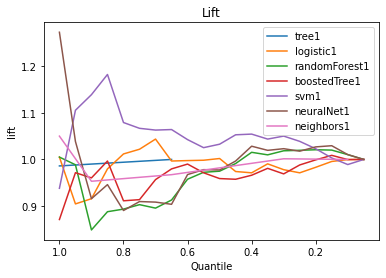

<Figure size 1440x2160 with 0 Axes>

In [103]:
for model in models1:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(lifts[model])
    plt.legend(lifts.keys())
plt.figure(figsize=(20,30))

In [104]:
# Boosted Trees is the best model in set 1
for model in models1:
    if model == 'boostedTree1':   
        predictions   = models1[model].predict(testing[features])
        probabilities = DataFrame(models1[model].predict_proba(testing[features]))[1]
        accuracy      = accuracy_score(testing[actual],predictions)
        auc           = roc_auc_score(array(testing[actual]),array(probabilities))
    
        performances[model] = {"Accuracy":accuracy,"AUC":auc}
act = pd.Series(testing[actual])
pred = pd.Series(predictions)
probab = pd.Series(probabilities)
testmodel6 = pd.concat([act, pred, probab], axis=1) 
testmodel6.columns = ['act', 'pred', 'probab']

# DataFrame of actual and predicted targets for the testing data campaign 7244
testmodel6

,act,pred,probab
0,0,0,0.468566
1,0,0,0.237771
2,0,1,0.505820
3,0,0,0.493149
4,0,0,0.129102
...,...,...,...
25640,0,0,0.129102
25641,0,0,0.294754
25642,0,0,0.403544
25643,0,0,0.121855


#### Best performing model = BoostedTrees
#### Population targetted = 21.49%
#### Success rate = 2.885%

In [105]:
p =(testmodel6['act'] == 1).sum()
(testmodel6['act'] == 1).sum()

361

In [106]:
a = testmodel6[testmodel6['act'] == 1]
q = (a['act'] == a['pred']).sum()
(a['act'] == a['pred']).sum()

164

In [107]:
r = (testmodel6['act'] == 0).sum()
(testmodel6['act'] == 0).sum()

25284

In [108]:
b = testmodel6[testmodel6['act'] == 0]
s = (b['act'] == b['pred']).sum()
(b['act'] == b['pred']).sum()

19747

In [109]:
percent_targetted = (q+r-s)/25645
percent_targetted

0.22230454279586664

In [110]:
success_rate = (q/(q+r-s))*100
success_rate

2.8766883002981936

### Second set of ML models :
#### Training data : Equal number of donors and non-donors from campaign 6169 (1191 donors, 1191 non-donors)
#### Testing data : Campaign 7244 (25645 donors)

In [111]:
models2 = {"tree2"        :tree,
          "logistic2"     :logistic,
          "randomForest2" :randomForest,
          "boostedTree2"  :boostedTree,
          "svm2"          :svm,
          "neuralNet2"    :neuralNet,
          "neighbors2"    :neighbors
         }

In [112]:
for model in models2:
    models2[model].fit(trainingdata[features],trainingdata[target])
    print(f"{model} has been trained successfully")

tree2 has been trained successfully
logistic2 has been trained successfully
randomForest2 has been trained successfully
boostedTree2 has been trained successfully
svm2 has been trained successfully
neuralNet2 has been trained successfully
neighbors2 has been trained successfully


In [113]:
performances2 = {}

for model in models2:
    predictions   = models2[model].predict(testing[features])
    probabilities = DataFrame(models2[model].predict_proba(testing[features]))[1]
    accuracy      = accuracy_score(testing[actual],predictions)
    auc           = roc_auc_score(array(testing[actual]),array(probabilities))
    performances2[model] = {"Accuracy":accuracy,"AUC":auc}

In [114]:
DataFrame(performances2)

,tree2,logistic2,randomForest2,boostedTree2,svm2,neuralNet2,neighbors2
Accuracy,0.720101,0.657594,0.690154,0.778631,0.575083,0.037551,0.549854
AUC,0.604113,0.623280,0.644255,0.673644,0.478951,0.582576,0.520153


In [115]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(testing[actual]).copy() 

for (index,model) in enumerate(models2):
    data[f"proba {model}"] = DataFrame(models2[model].predict_proba(training[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "actual_target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "actual_target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "actual_target", probability = "proba "+str(model))
            

In [116]:
data.head()

,actual_target,proba tree2,proba logistic2,proba randomForest2,proba boostedTree2,proba svm2,proba neuralNet2,proba neighbors2
0,0,0.0,0.586635,0.58,0.530990,0.511500,0.880639,0.8
1,0,0.0,0.418861,0.53,0.120252,0.512868,0.841327,0.4
2,0,1.0,0.662496,0.58,0.541721,0.506454,0.997220,0.4
3,0,0.0,0.568165,0.34,0.547137,0.511407,0.881989,0.6
4,0,1.0,0.572572,0.57,0.346170,0.507946,0.711819,0.2


In [117]:
lifts.keys()

dict_keys(['tree2', 'logistic2', 'randomForest2', 'boostedTree2', 'svm2', 'neuralNet2', 'neighbors2'])

<Figure size 1440x2160 with 0 Axes>

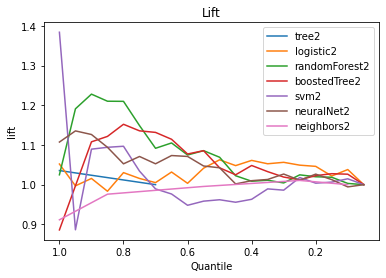

<Figure size 1440x2160 with 0 Axes>

In [118]:
for model in models2:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(lifts[model])
    plt.legend(lifts.keys())
plt.figure(figsize=(20,30))

In [119]:
for model in models2:
    if model == 'boostedTree2':   
        predictions   = models2[model].predict(testing[features])
        probabilities = DataFrame(models2[model].predict_proba(testing[features]))[1]
        accuracy      = accuracy_score(testing[actual],predictions)
        auc           = roc_auc_score(array(testing[actual]),array(probabilities))
        performances2[model] = {"Accuracy":accuracy,"AUC":auc}
donorID = pd.Series(testing['donorID'])
act = pd.Series(testing[actual])
pred = pd.Series(predictions)
probab = pd.Series(probabilities)
testmodel2 = pd.concat([donorID,act, pred, probab], axis=1) 
testmodel2.columns = ['donorID', 'act', 'pred', 'probab']

testmodel2 

,donorID,act,pred,probab
0,100001,0,1,0.530990
1,100002,0,0,0.120252
2,100008,0,1,0.547137
3,100009,0,0,0.346170
4,100010,0,0,0.100421
...,...,...,...,...
25640,144682,0,0,0.086068
25641,144683,0,0,0.229001
25642,144686,0,0,0.271359
25643,144690,0,0,0.112864


### Best performing model :  BoostedTrees
#### Population Targetted : 19.35%
#### Success Rate : 3.22%

In [120]:
p = (testmodel2['act'] == 1).sum()
(testmodel2['act'] == 1).sum()

361

In [121]:
a = testmodel2[testmodel2['act'] == 1]
q = (a['act'] == a['pred']).sum()
(a['act'] == a['pred']).sum()

176

In [122]:
r = (testmodel2['act'] == 0).sum()
(testmodel2['act'] == 0).sum()

25284

In [123]:
b = testmodel2[testmodel2['act'] == 0]
s = (b['act'] == b['pred']).sum()
(b['act'] == b['pred']).sum()

19792

In [124]:
percent_targetted = (q+r-s)/25645
percent_targetted

0.22101774224995127

In [125]:
success_rate = (q/(q+r-s))*100
success_rate

3.10515172900494

### Third set of ML models
#### Training Data : Entire campaign 6169 (34888 rows)
#### Testing Data : Entire campaign 7244 (25645 rows)


In [126]:
models3 = {"tree3"        :tree,
          "logistic3"     :logistic,
          "randomForest3" :randomForest,
          "boostedTree3"  :boostedTree,
          "svm3"          :svm,
          "neuralNet3"    :neuralNet,
          "neighbors3"    :neighbors
         }

In [127]:
for model in models3:
    models3[model].fit(training[features],training[target])
    print(f"{model} has been trained successfully")

tree3 has been trained successfully
logistic3 has been trained successfully
randomForest3 has been trained successfully
boostedTree3 has been trained successfully
svm3 has been trained successfully
neuralNet3 has been trained successfully
neighbors3 has been trained successfully


In [128]:
performances3 = {}

for model in models3:
    predictions   = models3[model].predict(testing[features])
    probabilities = DataFrame(models3[model].predict_proba(testing[features]))[1]
    accuracy      = accuracy_score(testing[actual],predictions)
    auc           = roc_auc_score(array(testing[actual]),array(probabilities))
    performances3[model] = {"Accuracy":accuracy,"AUC":auc}

In [129]:
DataFrame(performances3)

,tree3,logistic3,randomForest3,boostedTree3,svm3,neuralNet3,neighbors3
Accuracy,0.981868,0.985962,0.984714,0.984714,0.985923,0.985884,0.985533
AUC,0.530710,0.620649,0.658290,0.659710,0.516441,0.492237,0.529546


In [130]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(testing[actual]).copy() 

for (index,model) in enumerate(models3):
    data[f"proba {model}"] = DataFrame(models3[model].predict_proba(training[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "actual_target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "actual_target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "actual_target", probability = "proba "+str(model))
            

In [131]:
data.head()

,actual_target,proba tree3,proba logistic3,proba randomForest3,proba boostedTree3,proba svm3,proba neuralNet3,proba neighbors3
0,0,0.0,0.064804,0.01,0.033909,0.031941,3.755087e-12,0.0
1,0,0.0,0.023181,0.00,0.011307,0.033500,1.855067e-15,0.0
2,0,0.0,0.057644,0.01,0.047714,0.031169,2.159842e-09,0.0
3,0,0.0,0.043032,0.01,0.022918,0.031536,2.322372e-12,0.0
4,0,0.0,0.037856,0.05,0.025627,0.032106,1.491745e-08,0.0


<Figure size 1440x2160 with 0 Axes>

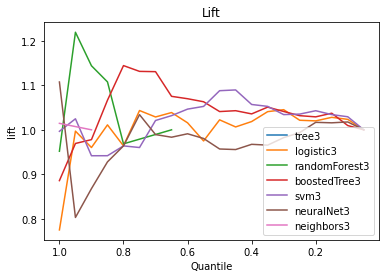

<Figure size 1440x2160 with 0 Axes>

In [132]:
for model in models3:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(lifts[model])
    plt.legend(lifts.keys())
plt.figure(figsize=(20,30))

In [133]:
for model in models3:
    if model == 'logistic3':   
        predictions   = models3[model].predict(testing[features])
        probabilities = DataFrame(models3[model].predict_proba(testing[features]))[1]
        accuracy      = accuracy_score(testing[actual],predictions)
        auc           = roc_auc_score(array(testing[actual]),array(probabilities))
        performances2[model] = {"Accuracy":accuracy,"AUC":auc}
act = pd.Series(testing[actual])
pred = pd.Series(predictions)
probab = pd.Series(probabilities)
testmodel3 = pd.concat([act, pred, probab], axis=1) 
testmodel3.columns = ['act', 'pred', 'probab']

testmodel3

,act,pred,probab
0,0,0,0.064804
1,0,0,0.023181
2,0,0,0.043032
3,0,0,0.037856
4,0,0,0.010819
...,...,...,...
25640,0,0,0.013926
25641,0,0,0.059201
25642,0,0,0.043941
25643,0,0,0.014795


### Best performing model : Logistic Regression
#### Population Targetted : 0.00035% (35 donors in a list of 1000000 donors)
#### Success Rate : 55.55%

In [134]:
p = (testmodel3['act'] == 1).sum()
p

361

In [135]:
a = testmodel3[testmodel3['act'] == 1]
q  = (a['act'] == a['pred']).sum()
q

5

In [136]:
r = (testmodel3['act'] == 0).sum()
r

25284

In [137]:
b = testmodel3[testmodel3['act'] == 0]
s = (b['act'] == b['pred']).sum()
s

25280

In [138]:
percent_targetted = (q+r-s)/25645
percent_targetted

0.0003509456034314681

In [139]:
success_rate = (q/(q+r-s))*100
success_rate

55.55555555555556

### Fourth Set of ML models
#### Data : Entire campaign 6169 data (34888 rows)
#### 75% to train the data, 25% to validate the data

In [140]:
partitions1 = partition(dataFrame = training, splitStrategy = [0.75,0.25])
for (index,dataFrame) in enumerate(partitions1):
    print(f"Partition {index} shape : {dataFrame.shape} ({len(dataFrame)/len(training)})")

trainingSet1   = partitions[0]
validationSet1 = partitions[1]


Partition 0 shape : (26166, 60) (0.75)
Partition 1 shape : (8722, 60) (0.25)


In [141]:
models4 = {"tree4"         :tree,
          "logistic4"     :logistic,
          "randomForest4" :randomForest,
          "boostedTree4"  :boostedTree,
          "svm4"          :svm,
          "neuralNet4"    :neuralNet,
          "neighbors4"    :neighbors
         }

In [142]:
for model in models4:
    models4[model].fit(trainingSet1[features],trainingSet1[target])
    print(f"{model} has been trained successfully")

tree4 has been trained successfully
logistic4 has been trained successfully
randomForest4 has been trained successfully
boostedTree4 has been trained successfully
svm4 has been trained successfully
neuralNet4 has been trained successfully
neighbors4 has been trained successfully


In [143]:
performances4 = {}

for model in models4:
    predictions   = models4[model].predict(validationSet1[features])
    probabilities = DataFrame(models4[model].predict_proba(validationSet1[features]))[1]
    accuracy      = accuracy_score(validationSet1[target],predictions)
    auc           = roc_auc_score(array(validationSet1[target]),array(probabilities))
    performances4[model] = {"Accuracy":accuracy,"AUC":auc}

In [144]:
DataFrame(performances4)

,tree4,logistic4,randomForest4,boostedTree4,svm4,neuralNet4,neighbors4
Accuracy,0.742857,0.588235,0.709244,0.808403,0.470588,0.591597,0.564706
AUC,0.742927,0.656942,0.770372,0.896044,0.501525,0.614797,0.588420


In [145]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(validationSet1[target]).copy() 

for (index,model) in enumerate(models4):
    data[f"proba {model}"] = DataFrame(models4[model].predict_proba(trainingSet1[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "target", probability = "proba "+str(model))
            

In [146]:
data.head()

,target,proba tree4,proba logistic4,proba randomForest4,proba boostedTree4,proba svm4,proba neuralNet4,proba neighbors4
0,0,0.0,0.513991,0.11,0.141361,0.492682,0.542632,0.2
1,0,1.0,0.511768,0.80,0.945637,0.492504,0.591109,0.6
2,0,0.0,0.700711,0.11,0.313818,0.492470,0.494124,0.2
3,1,1.0,0.324635,0.63,0.580510,0.492499,0.344818,0.6
4,0,0.0,0.630472,0.19,0.431431,0.492961,0.761420,0.4


<Figure size 1440x2160 with 0 Axes>

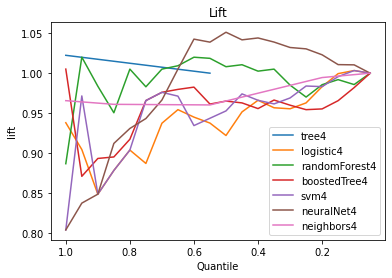

<Figure size 1440x2160 with 0 Axes>

In [147]:
for model in models4:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(lifts[model])
    plt.legend(lifts.keys())
plt.figure(figsize=(20,30))

In [148]:
for model in models4:
    if model == 'boostedTree4':   
        predictions   = models4[model].predict(testing[features])
        probabilities = DataFrame(models4[model].predict_proba(testing[features]))[1]
        accuracy      = accuracy_score(testing[actual],predictions)
        auc           = roc_auc_score(array(testing[actual]),array(probabilities))
        performances2[model] = {"Accuracy":accuracy,"AUC":auc}
act = pd.Series(testing[actual])
pred = pd.Series(predictions)
probab = pd.Series(probabilities)
testmodel4 = pd.concat([act, pred, probab], axis=1) 
testmodel4.columns = ['act', 'pred', 'probab']

testmodel4

,act,pred,probab
0,0,0,0.468566
1,0,0,0.237771
2,0,1,0.505820
3,0,0,0.493149
4,0,0,0.129102
...,...,...,...
25640,0,0,0.129102
25641,0,0,0.258642
25642,0,0,0.403544
25643,0,0,0.121855


### Best performing model : BoostedTrees
#### Population Targetted : 21.48%
#### Success Rate : 2.88%

In [149]:
p = (testmodel4['act'] == 1).sum()

In [150]:
a = testmodel4[testmodel4['act'] == 1]
q = (a['act'] == a['pred']).sum()

In [151]:
r = (testmodel4['act'] == 0).sum()

In [152]:
b = testmodel4[testmodel4['act'] == 0]
s = (b['act'] == b['pred']).sum()

In [153]:
percent_targetted = (q+r-s)/25645
percent_targetted

0.22230454279586664

In [154]:
success_rate = (q/(q+r-s))*100
success_rate

2.8766883002981936

## Model Performance for Campaign 7662

In [155]:
camp7662 = pd.read_csv('selection campaign 7662 (without gifts).csv', delimiter = ';')
camp7662.head()

,donorID
0,134242
1,126503
2,104392
3,105905
4,120506


In [156]:
print(camp7662.isna().sum())
print('\n')
print(camp7662.nunique())
print('\n')
print(camp7662.dtypes)
camp6169.head()

donorID    0
dtype: int64


donorID    26522
dtype: int64


donorID    int64
dtype: object


,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [157]:
# Donors who donated in 7662 campaign 
target_var = gifts_clean1[gifts_clean1['campaignID'] == 7662]
target_var['target'] = 1
target_var.head()

,donorID,campaignID,amount,date,campaignIDNew,timediff,target


In [158]:
test7662 = pd.merge(camp7662, donors, on='donorID', how='inner')
test7662 = pd.merge(test7662, gifts_agg, on='donorID', how='outer')
test7662 = pd.merge(test7662, gifts5agg, on='donorID', how='outer')
test7662 = pd.merge(test7662, gifts3agg, on='donorID', how='outer')
test7662 = pd.merge(test7662, gifts1agg, on='donorID', how='outer')
test7662 = pd.merge(camp7662, test7662, on='donorID', how='inner')


In [159]:
test7662.head()

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,IsFromBrussels,IsFromWallonia,Number_of_donations,Total_amount,in_last5_years,Total_amount5,in_last3_years,Total_amount3,in_last1_years,Total_amount1
0,134242,53.0,1.0,0.0,0.0,0.0,0.0,0.0,3580.0,0.0,...,0.0,0.0,2.0,30.00,1.0,10.0,NaN,NaN,NaN,NaN
1,126503,70.0,1.0,0.0,0.0,0.0,0.0,0.0,4250.0,0.0,...,0.0,1.0,1.0,50.00,1.0,50.0,NaN,NaN,NaN,NaN
2,104392,45.0,0.0,1.0,0.0,0.0,0.0,0.0,4820.0,0.0,...,0.0,1.0,1.0,50.00,1.0,50.0,NaN,NaN,NaN,NaN
3,105905,49.0,1.0,0.0,0.0,0.0,0.0,0.0,8370.0,0.0,...,0.0,0.0,2.0,210.00,0.0,55.0,0.0,55.0,NaN,NaN
4,120506,46.0,1.0,0.0,0.0,0.0,0.0,0.0,8020.0,0.0,...,0.0,0.0,5.0,61.89,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
test7662.columns

Index(['donorID', 'age', 'IsMale', 'IsFemale', 'IsMissingGender',
       'IsMissingZipCode', 'IsMissingProvince', 'IsMissingRegion', 'NewZip',
       'province_Antwerp', 'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'Speaks_NL',
       'Speaks_FR', 'IsFromFlanders', 'IsFromBrussels', 'IsFromWallonia',
       'Number_of_donations', 'Total_amount', 'in_last5_years',
       'Total_amount5', 'in_last3_years', 'Total_amount3', 'in_last1_years',
       'Total_amount1'],
      dtype='object')

In [161]:
test7662 = test7662.drop(test7662.columns[[28,30,32]], axis = 1)

In [162]:
test7662.isna().sum()

donorID                         0
age                             0
IsMale                          0
IsFemale                        0
IsMissingGender                 0
IsMissingZipCode                0
IsMissingProvince               0
IsMissingRegion                 0
NewZip                          0
province_Antwerp                0
province_Brussels               0
province_East Flanders          0
province_Flemish Brabant        0
province_Hainaut                0
province_Liege                  0
province_Limburg                0
province_Luxembourg             0
province_Namur                  0
province_Walloon Brabant        0
province_West Flanders          0
Speaks_NL                       0
Speaks_FR                       0
IsFromFlanders                  0
IsFromBrussels                  0
IsFromWallonia                  0
Number_of_donations             4
Total_amount                    4
in_last5_years              13712
in_last3_years              17074
in_last1_years

In [163]:
test7662 = test7662.replace(np.nan, 0)

In [164]:
test7662['IsMale'] = test7662['IsMale'].astype(int)
test7662['age'] = test7662['age'].astype(int)
test7662['NewZip'] = test7662['NewZip'].astype(int)
test7662['Number_of_donations'] = test7662['Number_of_donations'].astype(int)
test7662['in_last5_years'] = test7662['in_last5_years'].astype(int)
test7662['in_last3_years'] = test7662['in_last3_years'].astype(int)
test7662['in_last1_years'] = test7662['in_last1_years'].astype(int)


In [165]:
for model in models2:
    if model == 'boostedTree2':   
        predictions   = models2[model].predict(test7662[features])
        probabilities = DataFrame(models2[model].predict_proba(test7662[features]))[1]
donorID = pd.Series(test7662['donorID'])        
pred = pd.Series(predictions)
probab = pd.Series(probabilities)
output = pd.concat([donorID, pred, probab], axis=1) 
output.columns = ['donorID', 'pred', 'probab']

output

,donorID,pred,probab
0,134242,0,0.114613
1,126503,0,0.306549
2,104392,0,0.279020
3,105905,0,0.318245
4,120506,0,0.255440
...,...,...,...
26517,114719,0,0.082566
26518,134824,0,0.265969
26519,143259,0,0.182789
26520,123936,1,0.554784


In [166]:
output[output['pred'] == 1]

,donorID,pred,probab
5,128540,1,0.500942
8,140682,1,0.778207
12,111013,1,0.913767
16,121937,1,0.818341
19,112360,1,0.617340
...,...,...,...
26506,106316,1,0.686333
26510,104667,1,0.504403
26511,141401,1,0.589028
26515,137273,1,0.924600


In [167]:
output.to_csv('output.csv', index = False) 

In [168]:
population_targetted = 7713/26522
population_targetted

0.29081517230978055

In [169]:
# Creation of the ideal profile of a donor

#We merged the testing to get all the features with the testmodel2 which performs the best among our 4 sets. 

#To get insights about the ideal donor, we filtered on the probability superior to 85% and check the average age, dominant region, language and gender of them. 

In [170]:
idealprofile = pd.merge(testing, testmodel2, on='donorID', how='inner')

In [171]:
idealprofile

,donorID,age,IsMale,IsFemale,IsMissingGender,IsMissingZipCode,IsMissingProvince,IsMissingRegion,NewZip,province_Antwerp,...,p donation IsFromBrussels,p donation IsFromWallonia,p donation Number_of_donations,p donation Total_amount,p donation in_last5_years,p donation in_last3_years,p donation in_last1_years,act,pred,probab
0,100001,52,0,1.0,0.0,0.0,0.0,0.0,1861,0.0,...,0.034424,0.034399,0.036991,0.034301,0.032281,0.031772,0.033284,0,1,0.530990
1,100002,67,1,0.0,0.0,0.0,0.0,0.0,2260,1.0,...,0.034424,0.034399,0.032862,0.033880,0.034545,0.038690,0.033284,0,0,0.120252
2,100008,82,1,0.0,0.0,0.0,0.0,0.0,1780,0.0,...,0.034424,0.034399,0.033650,0.034157,0.032281,0.031772,0.033284,0,1,0.547137
3,100009,87,1,0.0,0.0,0.0,0.0,0.0,1020,0.0,...,0.024958,0.034399,0.040650,0.034700,0.032281,0.031772,0.033284,0,0,0.346170
4,100010,36,1,0.0,0.0,0.0,0.0,0.0,1020,0.0,...,0.024958,0.034399,0.032862,0.033933,0.034545,0.038690,0.033284,0,0,0.100421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,144682,37,1,0.0,0.0,0.0,0.0,0.0,1640,0.0,...,0.034424,0.034399,0.032862,0.033933,0.034545,0.038690,0.033284,0,0,0.086068
25641,144683,34,0,0.0,1.0,0.0,0.0,0.0,9308,0.0,...,0.034424,0.034399,0.032474,0.033959,0.032281,0.031772,0.033284,0,0,0.229001
25642,144686,55,0,1.0,0.0,0.0,0.0,0.0,2440,1.0,...,0.034424,0.034399,0.032862,0.033959,0.034545,0.038690,0.033284,0,0,0.271359
25643,144690,43,1,0.0,0.0,0.0,0.0,0.0,1950,0.0,...,0.034424,0.034399,0.032862,0.033933,0.034545,0.031772,0.033284,0,0,0.112864


In [172]:
idealprofile[(idealprofile.probab >=0.85)][['IsMale', 'age']].groupby('IsMale').agg('mean')

,age
IsMale,
0,66.795455
1,55.324138


In [173]:
idealprofile[(idealprofile.probab >=0.85)][['IsMale', 'donorID']].groupby('IsMale').agg('count')

,donorID
IsMale,
0,220
1,145


In [174]:
idealprofile[(idealprofile.probab >=0.85)][['donorID', 'Speaks_NL']].groupby('Speaks_NL').agg('count')     

,donorID
Speaks_NL,
0.0,46
1.0,319


In [175]:
idealprofile[(idealprofile.probab >=0.85)][['donorID', 'Speaks_FR']].groupby('Speaks_FR').agg('count') 

,donorID
Speaks_FR,
0.0,319
1.0,46


In [176]:

idealprofile[(idealprofile.probab >=0.85)][['donorID', 'IsFromFlanders']].groupby('IsFromFlanders').agg('count') 

,donorID
IsFromFlanders,
0.0,43
1.0,322


In [177]:
idealprofile[(idealprofile.probab >=0.85)][['donorID', 'IsFromBrussels']].groupby('IsFromBrussels').agg('count') 

,donorID
IsFromBrussels,
0.0,360
1.0,5


In [178]:
idealprofile[(idealprofile.probab >=0.85)][['donorID', 'IsFromWallonia']].groupby('IsFromWallonia').agg('count') 

,donorID
IsFromWallonia,
0.0,327
1.0,38
